In [2]:
import re, os, glob, pandas as pd
import editdistance

In [ ]:
## Import token totals
os.chdir("C://Users//Ruben//Documents//GitHub//TheForeign//SCC//output-data")
token_totals = pd.read_csv('tokens_year.csv')

## Import Master DF
os.chdir("C://Users//Ruben//Documents//Scriptie//Data//cngwf2//output")
df = pd.read_csv('total-bigrams.csv')

## Define ED function
def GetCloseED(master_df, search_term):
    output_list = list()
    
    subset_df = master_df[master_df.ngram.str[0] == search_term[0]]
    
    for word in list(subset_df.ngram):
        ed = editdistance.eval(search_term, word)
        if ed < 3:
            output_list.append(word)
    
    return output_list

In [15]:
test = df[df.ngram.str[0] == "b"]
test = test[test.ngram.str.split().str.len() > 1]

_Extract Unigrams_

In [18]:
df_buit = df[df.ngram.str.split().str[0].isin(GetCloseED(df, "buitenlandsche"))]
df_buit = df_buit.reset_index(drop=True)
df_buit = df_buit.dropna()
df_buit['year'] = df_buit['year'].astype(int)
df_buit = df_buit.pivot(index='ngram', columns='year', values='count')
df_buit = df_buit.fillna(0)
df_buit.columns = df_buit.columns.astype(str)

MemoryError: 

In [60]:
list_sums = list()

for i in list(df_buit.columns):
    tmp = sum(df_buit[i].astype(int))
    list_sums.append(tmp)

In [61]:
token_totals['buitenlandsche'] = list_sums
token_totals['buitenlandsche'] = token_totals['buitenlandsche'] / token_totals['tokens'] * 100

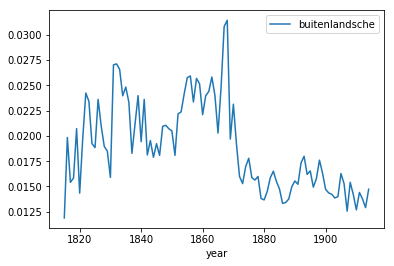

In [62]:
plot = token_totals.plot.line(x='year', y='buitenlandsche')

In [63]:
token_totals.to_csv("unigrams_buitenlandsche.csv", index=False)

In [66]:
df_buit.to_csv('raw_ocr_alt_buitenlandsche.csv', index=False)

In [ ]:
## Get 'Buitenland'
df_buit = df[df.ngram.isin(GetCloseED(df, "buitenland"))]
df_buit = df_buit[df_buit.ngram.str.len() == 10]
df_buit = df_buit.reset_index(drop=True)
df_buit = df_buit.dropna()
df_buit['year'] = df_buit['year'].astype(int)
df_buit = df_buit.pivot(index='ngram', columns='year', values='count')
df_buit = df_buit.fillna(0)
df_buit.columns = df_buit.columns.astype(str)
list_sums = list()

for i in list(df_buit.columns):
    tmp = sum(df_buit[i].astype(int))
    list_sums.append(tmp)

token_totals['buitenlandsche'] = list_sums
token_totals['buitenlandsche'] = token_totals['buitenlandsche'] / token_totals['tokens'] * 100
plot = token_totals.plot.line(x='year', y='buitenlandsche')

In [16]:
df_buit

NameError: name 'df_buit' is not defined